In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    print(f"CUDA not available, using CPU: {device}")

# Set device globally
torch.cuda.empty_cache() if torch.cuda.is_available() else None

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Ti
CUDA version: 12.4
Using device: cuda


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = Path(r"C:\Users\furqu\OneDrive - UC Leuven-Limburg\Third year\Projects\Gassy\test\classifier-setup\data\sorted_data")

# augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
print("Classes found:", class_names)
print("Number of classes:", len(class_names))

dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset_temp = random_split(full_dataset, [train_size, val_size])

val_dataset = torch.utils.data.Subset(
    datasets.ImageFolder(root=data_dir, transform=val_transform),
    val_dataset_temp.indices
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"training samples: {len(train_dataset)}")
print(f"validation samples: {len(val_dataset)}")
print(f"training batches: {len(train_loader)}")
print(f"validation batches: {len(val_loader)}")

Classes found: ['damaged_bottle', 'dirty_bottle', 'notprimagass_bottle', 'ok_bottle']
Number of classes: 4
training samples: 416
validation samples: 105
training batches: 13
validation batches: 4


In [23]:
import torchvision.models as models

class ConvNeXtClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeXtClassifier, self).__init__()

        self.backbone = models.convnext_base(weights='DEFAULT')
        
        # Get the correct input features for the classifier
        # ConvNeXt uses a different structure than ResNet
        if hasattr(self.backbone, 'classifier'):
            # For ConvNeXt, the classifier is a Sequential with LayerNorm and Linear
            if isinstance(self.backbone.classifier, nn.Sequential):
                # Find the Linear layer in the classifier
                for module in self.backbone.classifier.modules():
                    if isinstance(module, nn.Linear):
                        in_features = module.in_features
                        break
            else:
                in_features = self.backbone.classifier.in_features
        else:
            # Fallback - this shouldn't happen with ConvNeXt
            in_features = 1024
        
        # Replace the classifier with our custom one
        # Need to add a Flatten layer before LayerNorm since ConvNeXt outputs 4D tensor
        self.backbone.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Ensure spatial dimensions are (1,1)
            nn.Flatten(),  # Flatten from [B, C, 1, 1] to [B, C]
            nn.LayerNorm(in_features, eps=1e-6),
            nn.Linear(in_features, num_classes)
        )
        
        print(f"Using ConvNeXt-Base model with {in_features} input features")
    
    def forward(self, x):
        return self.backbone(x)

# Initialize model
num_classes = len(class_names)
model = ConvNeXtClassifier(num_classes)

# Move model to GPU if available
model = model.to(device)
print(f"Model moved to: {device}")

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Freeze backbone features for transfer learning
if hasattr(model.backbone, 'features'):
    for param in model.backbone.features.parameters():
        param.requires_grad = False
    print("Frozen ConvNeXt backbone features")

trainable_params_frozen = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters after freezing: {trainable_params_frozen:,}")

# Test the model with a dummy input to verify shapes
print("\nTesting model with dummy input...")
dummy_input = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input)
print(f"Model output shape: {dummy_output.shape}")
print(f"Expected shape: torch.Size([1, {num_classes}])")
assert dummy_output.shape == torch.Size([1, num_classes]), f"Output shape mismatch! Got {dummy_output.shape}, expected [1, {num_classes}]"
print("✓ Model architecture verified successfully!")

Using ConvNeXt-Base model with 1024 input features
Model moved to: cuda
Total parameters: 87,570,564
Trainable parameters: 87,570,564
Frozen ConvNeXt backbone features
Trainable parameters after freezing: 6,148

Testing model with dummy input...
Model output shape: torch.Size([1, 4])
Expected shape: torch.Size([1, 4])
✓ Model architecture verified successfully!


In [20]:
# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device='cuda'):
    best_val_acc = 0.0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.cpu().numpy())
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)
        
        val_epoch_loss = val_running_loss / val_total_samples
        val_epoch_acc = val_running_corrects.double() / val_total_samples
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.cpu().numpy())
        
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")
        
        # Learning rate scheduling
        scheduler.step(val_epoch_loss)
        print()
    
    # Load best model at the end
    model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    
    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }

Epoch 1/30
------------------------------
Batch 10/13, Loss: 0.4994
Batch 10/13, Loss: 0.4994
Train Loss: 0.3987, Train Acc: 0.8558
Val Loss: 0.5296, Val Acc: 0.8000
New best model saved with validation accuracy: 0.8000

Epoch 2/30
------------------------------
Train Loss: 0.3987, Train Acc: 0.8558
Val Loss: 0.5296, Val Acc: 0.8000
New best model saved with validation accuracy: 0.8000

Epoch 2/30
------------------------------
Batch 10/13, Loss: 0.4498
Batch 10/13, Loss: 0.4498
Train Loss: 0.4174, Train Acc: 0.8438
Val Loss: 0.5195, Val Acc: 0.8095
Train Loss: 0.4174, Train Acc: 0.8438
Val Loss: 0.5195, Val Acc: 0.8095
New best model saved with validation accuracy: 0.8095

Epoch 3/30
------------------------------
New best model saved with validation accuracy: 0.8095

Epoch 3/30
------------------------------
Batch 10/13, Loss: 0.5699
Batch 10/13, Loss: 0.5699
Train Loss: 0.3710, Train Acc: 0.8798
Val Loss: 0.4946, Val Acc: 0.8095

Epoch 4/30
------------------------------
Train Loss:

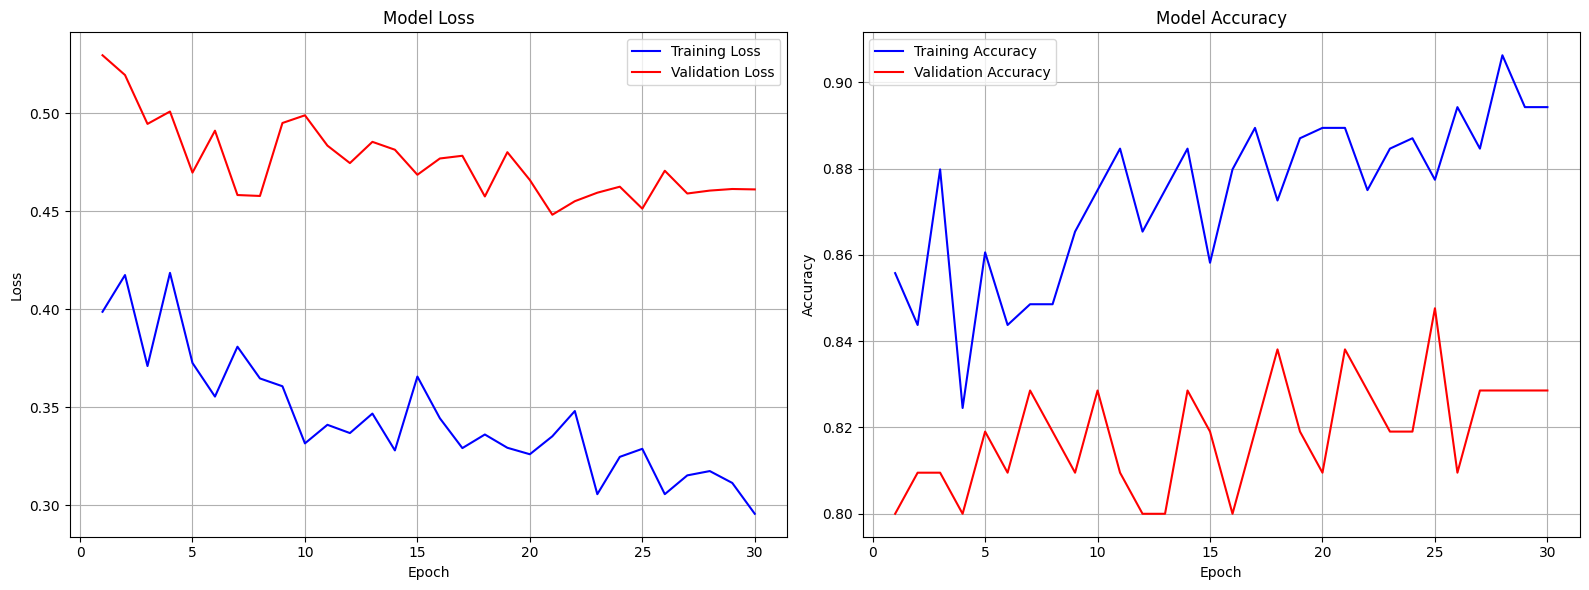

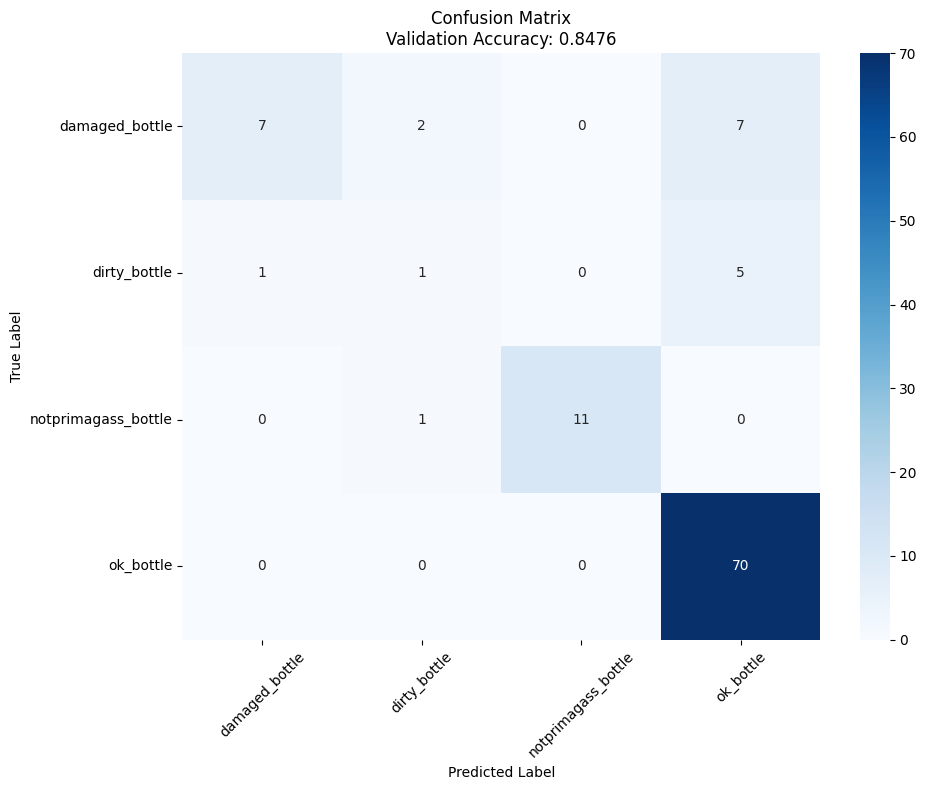


Model saved to: trained_convnext_classifier.pth
Final validation accuracy: 0.8476


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-7)

training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,
    device=device
)

def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

# prediction
y_true, y_pred = evaluate_model(model, val_loader, device, class_names)

# accuracy
accuracy = np.mean(y_true == y_pred)

# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# plot training history
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix\nValidation Accuracy: {accuracy:.4f}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

model_save_path = "trained_convnext_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'num_classes': len(class_names),
    'model_architecture': 'ConvNeXt' if hasattr(model.backbone, 'classifier') else 'ResNet50',
    'final_accuracy': accuracy,
    'training_history': training_history
}, model_save_path)

print(f"\nModel saved to: {model_save_path}")
print(f"Final validation accuracy: {accuracy:.4f}")

In [27]:
# This cell has been removed - model saving integrated into cell 6

# Function to load the model for inference (keep this for later use)
def load_trained_model(model_path, device='cuda'):
    """Load the trained model for inference"""
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Recreate model architecture
    num_classes = checkpoint['num_classes']
    model = ConvNeXtClassifier(num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, checkpoint['class_names']

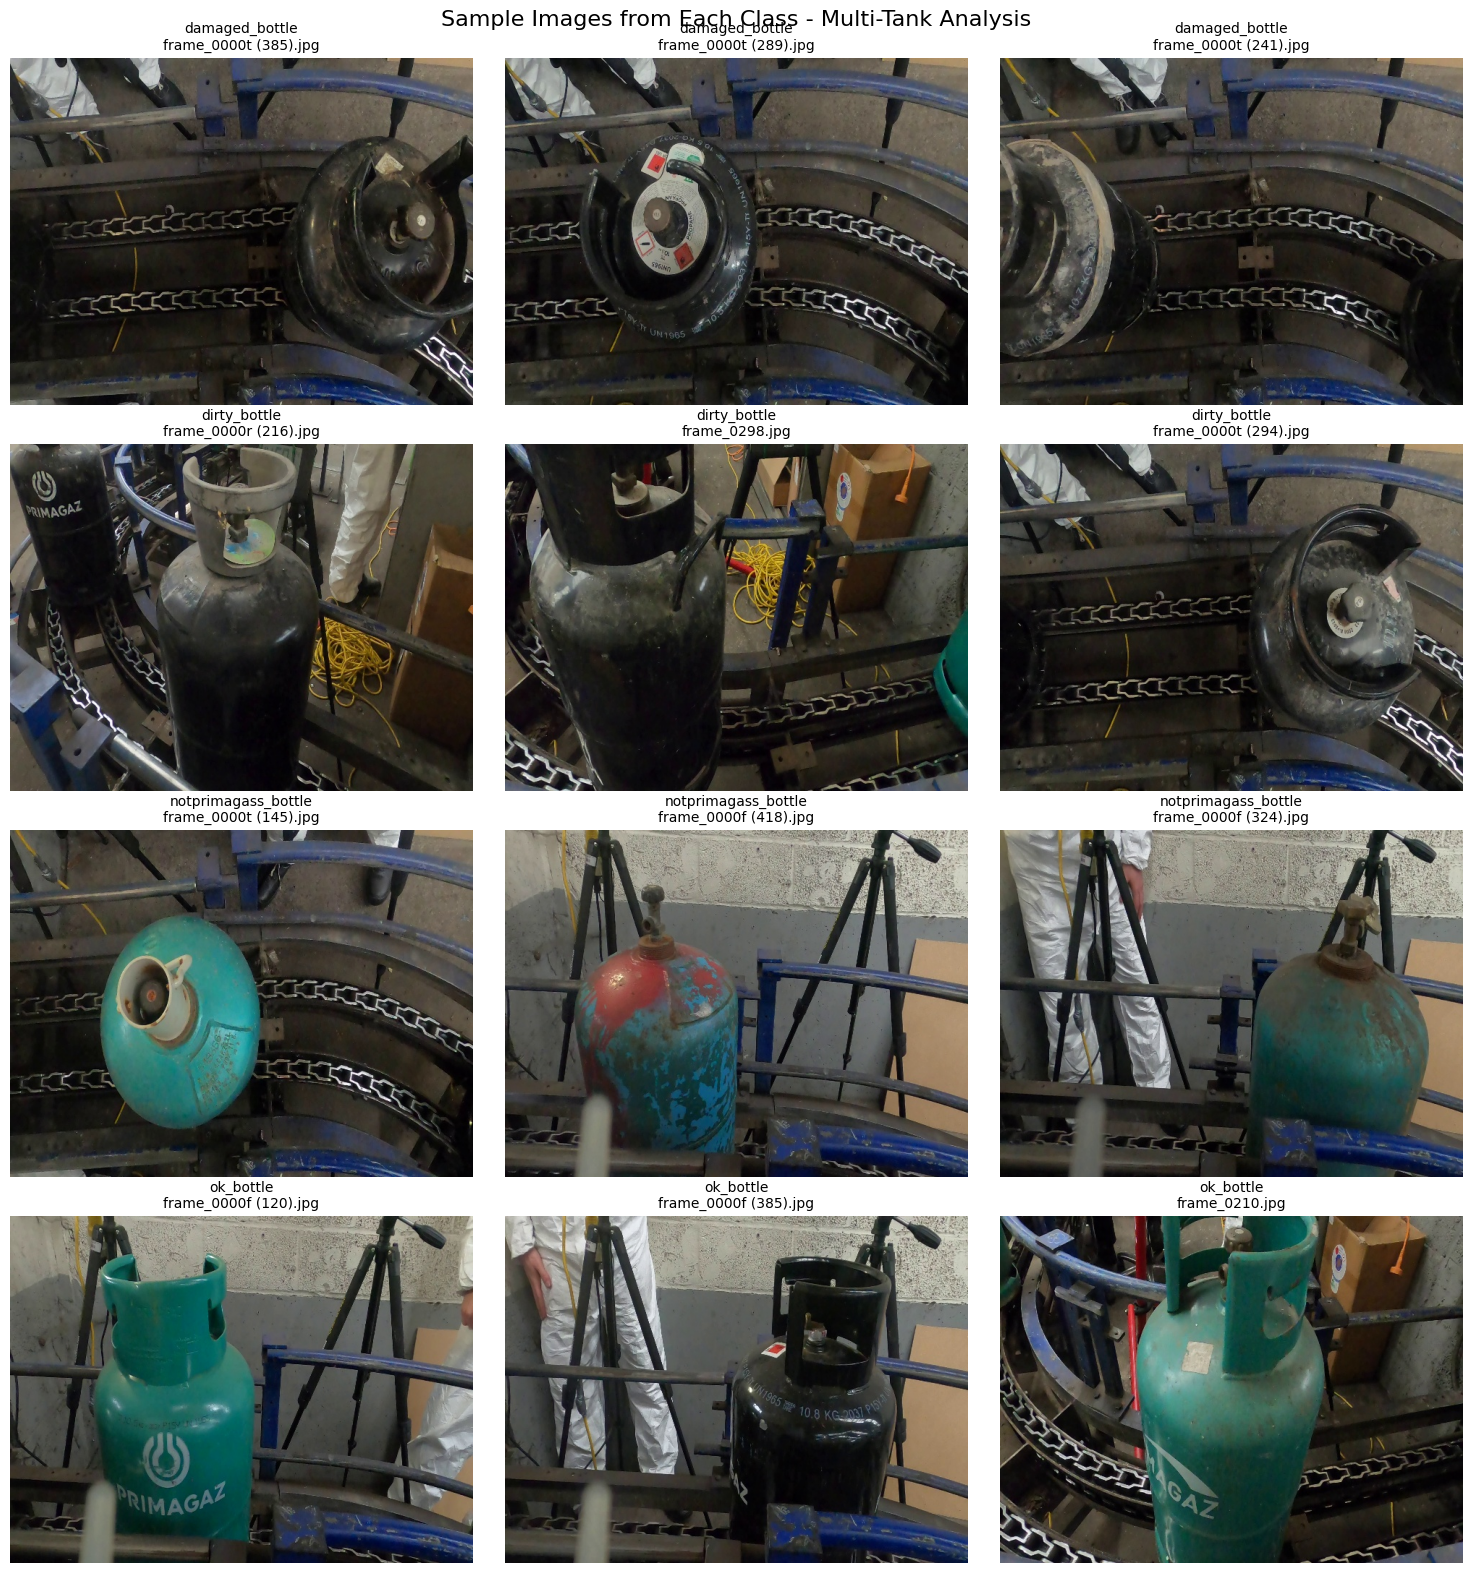

🔍 ANALYSIS QUESTIONS TO CONSIDER:
1. Do you see multiple tanks in single images?
2. Are tanks consistently centered and well-framed?
3. Do images with multiple tanks have consistent quality labels?
4. Would cropping individual tanks improve classification?


In [28]:
# Quick analysis: Check if multi-tank images are causing classification issues
import random
from PIL import Image
import matplotlib.patches as patches

def analyze_data_quality(data_dir, class_names, num_samples_per_class=3):
    """Analyze a few sample images from each class to check for multi-tank scenarios"""
    
    fig, axes = plt.subplots(len(class_names), num_samples_per_class, 
                            figsize=(15, 4 * len(class_names)))
    fig.suptitle('Sample Images from Each Class - Multi-Tank Analysis', fontsize=16)
    
    for class_idx, class_name in enumerate(class_names):
        class_path = data_dir / class_name
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
        
        # Sample random images
        sample_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))
        
        for img_idx, img_path in enumerate(sample_images):
            ax = axes[class_idx, img_idx] if len(class_names) > 1 else axes[img_idx]
            
            # Load and display image
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f'{class_name}\n{img_path.name}', fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🔍 ANALYSIS QUESTIONS TO CONSIDER:")
    print("1. Do you see multiple tanks in single images?")
    print("2. Are tanks consistently centered and well-framed?")
    print("3. Do images with multiple tanks have consistent quality labels?")
    print("4. Would cropping individual tanks improve classification?")

# Run the analysis
analyze_data_quality(data_dir, class_names, num_samples_per_class=3)

In [ ]:
plot_training_history(training_history)